### Truncated copula MLE

In [1]:
# Load everything - Gamma
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import rbf_kernel as rbf
from math import sqrt
from joblib import Parallel, delayed
import psutil
import math
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
import scipy.sparse
import warnings


#from parallel.backends import BackendDummy as Backend
#backend = Backend()
#################
with open('Data_for_truncated_copula/inv_Us.txt','rb') as f:
    inv_us = pickle.load(f)

with open('Data_for_truncated_copula/did_rain_01.txt','rb') as f:
    did_rain_01 = pickle.load(f)

with open('Data_for_truncated_copula/g2_us.txt','rb') as f:
    g2_us = pickle.load(f)

with open('Data_for_truncated_copula/dist_mat.txt','rb') as f:
    dist_mat = pickle.load(f)

In [2]:
# Functions

# MC estimate - Correct and working
def mc_cdf(rvs,cov_matrix,ppf_us):
    '''
    rvs: [[set1], ... , [set m]] each set of length = #locations = n.
    cov_matrix: covariance matrix between the locations in question.
    ppf_us: [u1, ... , un] length = # locs.
    '''    
    # rvs are mean 0 already, but need different covariance
    cholesk_mat = np.linalg.cholesky(cov_matrix)
    normcov_vars = [np.asarray(cholesk_mat@rvs[i])[0] for i in range(len(rvs))]
    out = max(1e-13,np.sum([np.sum([normcov_vars[m][n]<ppf_us[n] for n in range(len(ppf_us))])==len(ppf_us) for m in range(len(normcov_vars))]))
    return out/len(rvs)       

# Truncated Gaussian copula class
class truncgauss():
    def __init__(self,L):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
    
    def sim(self,theta,draws):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        #later

    def nll(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                    submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                    submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                    submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                    
                    #### MC estimate part      ####

                    if len(submat22.todense())!=1:
                        sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

#function for single nll eval   

def nll_sub_days(days_list,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs,cov_mat):
    
    #warnings.filterwarnings("ignore")

    nll=0
    for day in days_list: #eg [251,...,500]
        # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
        if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
            nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
        else: # some dry -> use elegant cdf
            #print('elegant'+str(np.sum(did_rain[day])))
            if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

            else:
                
                # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                
                # create submatricies
                submat11 = coo_matrix(cov_mat[r_dry,c_dry])
                submat12 = csr_matrix(cov_mat[r_dry,c_rain])
                submat21 = csc_matrix(cov_mat[r_rain,c_dry])
                submat22 = coo_matrix(cov_mat[r_rain,c_rain])
                
                #### MC estimate part      ####

                if len(submat22.todense())!=1:
                    sub_cov = (submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense()
                else: # submat22 is an integer, aka only one non-zero obs
                    sub_cov = (submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense()
                # Do MC approximation to cdf
                nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                #### MC estimate part - end ####


                # compute and add the elegant cdf
                #if len(submat22.todense())==1:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                #else:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
        
        # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
        for loc in range(len(Invcdf_Us[0])):
            if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
            else:# dry: add cdf(invcdf(pi))
                nll -= np.log(truncation_pi[day][loc])
        

    return -nll    


In [18]:
# rvs for MC estimate
rand_vars = scs.multivariate_normal.rvs(np.zeros(len(dist_mat)),np.eye(len(dist_mat)),size=10000)
# length = size, each set is of length = #locs

In [3]:
# Covariance matrix
covariance_matrix = np.nan_to_num(rbf(dist_mat,gamma=1/(2*10*10)),copy=False,nan=0)

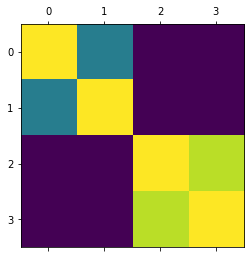

In [36]:
plt.matshow(covariance_matrix[1:5,1:5])

In [27]:
covariance_matrix[1:5,1:5]

array([[1.00000000e+00, 4.25697868e-01, 1.31310300e-31, 1.45424605e-33],
       [4.25697868e-01, 1.00000000e+00, 7.91790614e-35, 9.36989720e-37],
       [1.31310300e-31, 7.91790614e-35, 1.00000000e+00, 8.97821637e-01],
       [1.45424605e-33, 9.36989720e-37, 8.97821637e-01, 1.00000000e+00]])

In [58]:
a = np.where(covariance_matrix[1:5,1:5]>0.2)
b = np.where([a[0]!=a[1]])
#c = np.nonzero(b)
[a,b]

[(array([0, 0, 1, 1, 2, 2, 3, 3], dtype=int64),
  array([0, 1, 0, 1, 2, 3, 2, 3], dtype=int64)),
 (array([0, 0, 0, 0], dtype=int64), array([1, 2, 5, 6], dtype=int64))]

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

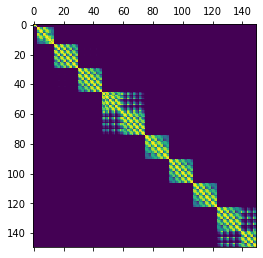

In [9]:
plt.matshow(covariance_matrix[:150,:150])

In [6]:
scs.multivariate_normal.cdf(x=inv_us[0][:16],mean=np.zeros(16),cov=covariance_matrix[:16,:16])

0.3877153280428165

In [5]:
#basic nll
#truncgauss(L=dist_mat).nll(theta=0.1,Invcdf_Us=[inv_us[i] for i in range(50)],truncation_pi=[g2_us[i] for i in range(50)],did_rain=[did_rain_01[i] for i in range(50)],len_locs=len(g2_us[0]),rvs = rand_vars) 
# locs:all , days:range(50) , theta:0.1 , time:3m28 , nll = -238511.6341627678

In [6]:
#nll on subsets of days
#truncgauss(L=dist_mat).nll_sub_days(days_list=range(50),Invcdf_Us=inv_us,truncation_pi=g2_us,did_rain=did_rain_01,len_locs=len(g2_us),rvs=rand_vars,cov_mat=covariance_matrix)
# locs:all , days:range(50) , theta:0.1 , time:1m30 + 25s , nll = -238511.6341627678

In [27]:
nll_sub_days(days_list=range(50),Invcdf_Us=inv_us,truncation_pi=g2_us,did_rain=did_rain_01,len_locs=len(g2_us),rvs=rand_vars,cov_mat=covariance_matrix)

KeyboardInterrupt: 

### Trying mp
not working rn

In [8]:
def my_func(days_list):
    out = 0
    for i in days_list:
        out+=1
    return out

In [14]:
def parallel_nll(theta):
    
    # Kernel
    cov_mat = covariance_matrix
    print('cov_mat')
    # parallel likelihood
    size = math.ceil(46/psutil.cpu_count())
    days_chuncks = [[i for i in range(46)][x:x+size] for x in range(0,46, size)]
    list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(nll_sub_days)(chunck,inv_us,g2_us,did_rain_01,len(g2_us),rand_vars,cov_mat) for chunck in tqdm(days_chuncks))
    #list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(my_func)(chunck) for chunck in tqdm(days_chuncks))
    
    return -np.sum(list_nll)
    #return [size, len(days_chuncks[0])]



In [15]:
parallel_nll(0.1)   

cov_mat


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
